## Purpose
the goal of this post is to better understand logistic regression. As usual, we'll walk through the intuition, the math, some code, metrics, and finally an example.

## What is Logistic Regression

Like linear regression, logistic regression is also a linear model, and also like linear regression, it is used for making real value predictions. So where does the logistic piece come in, and how is it a classifier? We basically pick up the standard linear equation, and plug it into a logistic regression. Doing this amounts to predicting the probability that an observation is part of class=0, or class =1. 

Just like how linear regression is a common used as a baseline model for regression problems, logistic regression is a common baseline model for classification problems. It is also a mathematically sound, simple model that does not require a large amount of data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, logistic
from scipy import stats
import seaborn as sns
import pandas as pd
from sklearn import datasets
from scipy.optimize import minimize


## Math Behind Logistic Regression

So the idea is we want to treat a classification problem as a regression problem. Ie. we want to draw a line through the points. To do this, a straigt line isn't going to cut it. So we need to put our linear model into a nonlinear function, known as a link function. We want this function to be "S" shaped, so it can go through the "1" class of points and the "0" class of points. What would be even better, is if it the regression value has *meaning*. What if, a $\hat{y}$ value of 0.8 means that the observation is 80% likily to be class 1. Or a value 0.2 meant it was 20% likily? That'd be useful, and make it *extremely* interpretable.

Enter Statistics.

The function described above fits the description of a cummulative distribution function (CDF). Let's do a quick detour and describe what this is.

Most people are familiar witha Normal distribution. When we think of any statistical distribution, we're usually thinking of a their probability distribution function (PDF). You can see it below.

<Figure size 500x500 with 0 Axes>

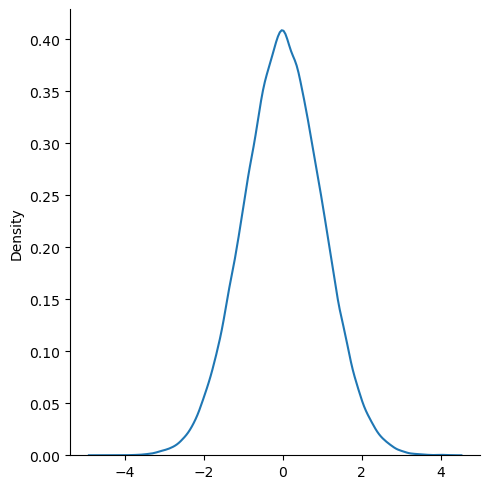

<Figure size 500x500 with 0 Axes>

In [2]:
sns.displot(norm.rvs(loc=0, scale=1,size=100_000),kind="kde")
plt.figure(figsize=(5,5))

The density function is very similar to a histogram. You can interpret the graph as follows: For any point on the line, the y-axis will indicate the probability of it occuring. So the probability of an observation falling around 0, is roughly 40%, whereas the probability of a point falling at 2 is roughly 10%.

What is the probability of a point being *less* than 2? This is where the CDF comes in. It turns out, if you take the integral of the PDF, you get the CDF. It looks like the grpah below, for the normal distribution. 


<Axes: xlabel='x', ylabel='Proportion'>

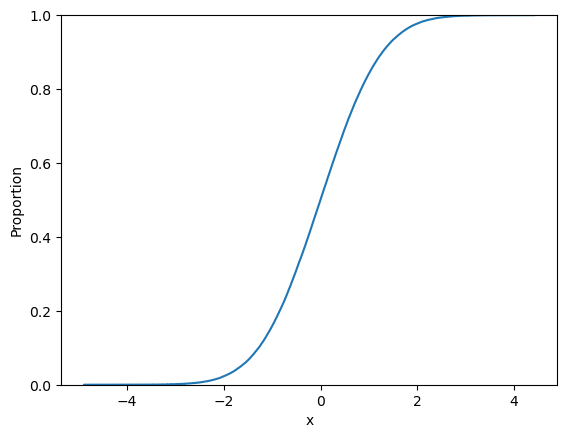

In [3]:
df = pd.DataFrame()
df["x"] = norm.rvs(loc=0, scale=1,size=100_000)
sns.ecdfplot(df,x="x")

So for the above graph, if x=2, we looke to the y axis to see the probability of values being less than or equal x=2. As illustrated in the graph below.

In this case, the probability of an observation being less than 2, is  0.9772498680518208


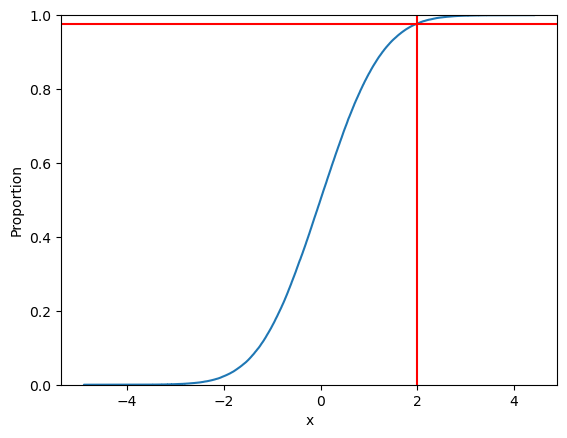

In [4]:
sns.ecdfplot(df,x="x")
plt.axvline(2,color="red")
plt.axhline(norm.cdf(2),color="red")
print("In this case, the probability of an observation being less than 2, is ", norm.cdf(2))

There is a lot neat math in this, but it is beyond the scope of this blog post to cover it. But alas, let's step off this detour and go back to the original problem. The above function does exactly what we want.

When the normal CDF is used as the basis for a classifier, it is known as a probit model. The model that is input ino the he logit model is the good old linear model.

$$
z = \beta_1 x_1 + ... + \beta_n x_n
$$

$$
probit(z) = \int{ \frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{z-\mu}{\sigma}^2 } }
$$

In [5]:
def probit(X):
    return norm.cdf(X) 

So this is great, but the one issue with it is that it can be computationally complicated, especially in the early days of computers. An alternative is the logit model, which happens to be CDF of the logistic distribution. 

Logit model:
    $$\hat{y}=\frac{1}{1 + e^{\vec{X}^T \vec{\beta}}}$$

In [6]:
 def logit(X):
    return logistic.cdf(X) 

The typical cost function for logistic regression is the Maximum Likilhood estimation (MLE). I would point you to most any Mathematical Statistics textbook for an understanding of what this means. But for our purposes, for the logit model, this amount to the following equation.


Loss Function:

$$
\beta = min \sum{-y log(\hat{y}) - (1-y) log(1-\hat{y})}
$$


Notice that $y$ is either 1 or 0. so we have two conditions in the equation above. If y = 1:
$$
\beta = min \sum{- log(\hat{y})}
$$

And if y = 0, then:
$$
\beta = min \sum{-log(1-\hat{y})}
$$

This particular loss function is known as the log-loss and used in a variety of binary classification algorithms now-a-days.

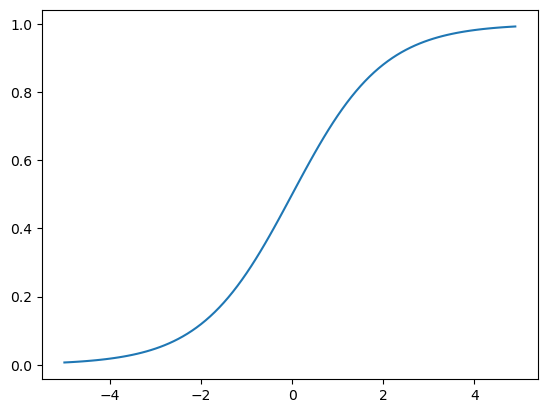

In [7]:
x = np.arange(-5,5,0.1)
y = logit(x)
plt.plot(x,y,alpha=1)

## Example

Where going to use two different subsets of the the iris dataset. One will result in a case that is linearly separable, and other will not be. The iris dataset has 3 classes, we are just going to use two of them for this example. We will also be limiting the model to only one feature, for visualization purposes.

So first lets load the dataset, and filter it down to 2 classes.

In [8]:
iris = datasets.load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

data = data[data["target"] < 2]
y = data["target"]

data.sample(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
96,5.7,2.9,4.2,1.3,1.0
48,5.3,3.7,1.5,0.2,0.0
84,5.4,3.0,4.5,1.5,1.0
16,5.4,3.9,1.3,0.4,0.0
76,6.8,2.8,4.8,1.4,1.0
20,5.4,3.4,1.7,0.2,0.0
47,4.6,3.2,1.4,0.2,0.0
13,4.3,3.0,1.1,0.1,0.0
19,5.1,3.8,1.5,0.3,0.0
58,6.6,2.9,4.6,1.3,1.0


Now, let's create the the logistic regression class. Per usual, we'll use NumPy so we can perform matrix operaitons (This results in cleaner equations and faster code). We'll define the loss function, optimization function (fit), and the predict function. Notice that the code matches the equations above nearly exactly.

We will be creating two different predict functions for this class. `predict_proba(X)` will return a real number between 0 and 1, which is the probability of the observation being of class=1. `predict(X,threshold)` will return either 1 or 0. If the probability of class 1 is greater than `threshold` it'll return 1, otherwise it'll return 0.

In [9]:
class logistic_regression:
    def __init__(self, X, y):
        self.betas = self.fit(X, y)    
    
    def loss_function(self,betas,X,y):
        y_hat = 1 / (1 + np.exp(-1 * betas @ X))
        loss = - y * np.log(y_hat) - (1 - y) * np.log(1-y_hat)
        return np.sum(loss)
    
    def fit(self,X, y):
        # Add Bias
        if len(X.shape) == 1:
            X=X.reshape(1,-1)
        X=np.append(X, np.ones(X.shape[1]).reshape(1,-1), 0)
        # Define loss function
        # Initialize parameters
        betas = np.random.normal(0,.001,X.shape[0])
        # Minimize loss function by adjusting parameters
        res = minimize(self.loss_function, x0=betas, args=(X, y))
        #Select optimized parameters
        betas = res.x        
        # Return optimized parameters
        return betas

    def predict_proba(self, X):
        if len(X.shape)==1:
            X=X.reshape(1,-1)
            X=np.append(X, np.ones(X.shape[1]).reshape(1,-1), 0)
        return logistic.cdf(self.betas @ X) 
        
    def predict(self, X, threshold=0.5):
        y_proba = self.predict_proba(X)
        y_hat = np.zeros(len(y_proba))
        y_hat[y_proba > 0.5] = 1
        return y_hat

First case will be linearly separable. In the graph below, the green dots are the observations, and the blue line is the prediction. Notice 100% accuracy.

/var/folders/_0/q1jpcbjj21x7krvplwn7jblc0000gn/T/ipykernel_5498/4053696788.py:7: RuntimeWarning: divide by zero encountered in log
  loss = - y * np.log(y_hat) - (1 - y) * np.log(1-y_hat)


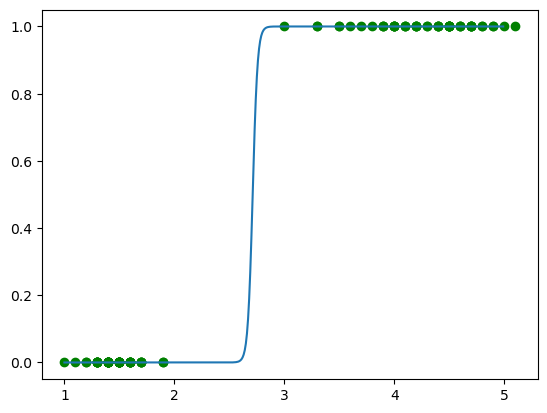

In [10]:
X = data["petal length (cm)"].values
X = X.T
lr = logistic_regression(X,y)
plt.scatter(X,y,c="green")
plt.plot(np.arange(1,5,0.01),lr.predict_proba(np.arange(1,5,0.01)))

Next we'll look at a case that isn't as clear cut. There are observations where the model is correct with a high probability, but there are other cases wher either the probability is lower, or the model is incorrect. 

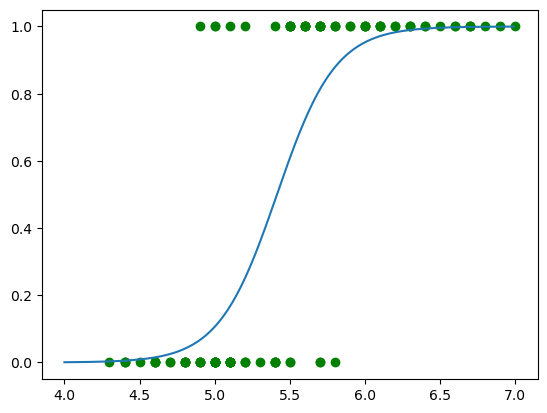

In [11]:
X = data["sepal length (cm)"].values
X = X.T
lr = logistic_regression(X,y)
plt.scatter(X,y,c="green")
plt.plot(np.arange(4,7,0.01),lr.predict(np.arange(4,7,0.01)))

## Common Metrics For Binary Classification Problems

Let's say we have a binary classification model called clf. For our test set, we have labeled data. Let's assume the following:

- **n**:= Count of total observations
- **Positive (P)**:= Count of observations in positive class (y=1)
- **Negative (N)**:= Count of observations in the negative class (y=0)
- **True Positive (TP)**:= Count of predictions that correctly label the observation as positive
- **True Negative (TN)**:= Count of predictions that correctly label the observation as negative
- **False Positive (FP)**:= Count of predictions that incorrectly label the observation as positive

Accuracy is the total the percent of correct predictions. Not good for imbalanced datasets. Ie. 10% of observations are positive, model predicts all obvservations are negative; model thus has 90% precision. 
- **Accuracy** =(TP+TN)/(P+N)

Precision is the percent of correctly labeled true positives, of the observations that were predicted to be positive.
- **Precision** = TP / (TP+FP)

Recall is the percent of correctly labeled true positives of all positive observations.
- **Recall** = TP/P

A harmonic mean. This is a good metric to use when you have an imbalanced dataset.
- **F1 Score** = (2TP) / (2TP+FP+FP+FN)

In [12]:
class logistic_regression:
    def __init__(self, X, y):
        self.betas = self.fit(X, y)    
    
    def loss_function(self,betas,X,y):
        y_hat = 1 / (1 + np.exp(-1 * betas @ X))
        loss = - y * np.log(y_hat) - (1 - y) * np.log(1-y_hat)
        return np.sum(loss)
    
    def fit(self,X, y):
        # Add Bias
        if len(X.shape) == 1:
            X=X.reshape(1,-1)
        X=np.append(X, np.ones(X.shape[1]).reshape(1,-1), 0)
        # Define loss function
        # Initialize parameters
        betas = np.random.normal(0,.001,X.shape[0])
        # Minimize loss function by adjusting parameters
        res = minimize(self.loss_function, x0=betas, args=(X, y))
        #Select optimized parameters
        betas = res.x        
        # Return optimized parameters
        return betas

    def predict_proba(self, X):
        if len(X.shape)==1:
            X=X.reshape(1,-1)
            X=np.append(X, np.ones(X.shape[1]).reshape(1,-1), 0)
        return (1 / (1 + np.exp(-1 * self.betas @ X)))

    def predict(self, X, threshold=0.5):
        y_proba = self.predict_proba(X)
        y_hat = np.zeros(len(y_proba))
        y_hat[y_proba > threshold] = 1
        return y_hat
    
    def get_metrics(self, X, y, threshold=0.5):
        metrics = {}
        y_hat = self.predict(X)
        P = np.sum(y)
        N = len(y) - P
        TP = y[y_hat==1].sum()         # count when y==1 & y_hat==1
        FN = y[y_hat==0].sum()         # count when y==1 & y_hat==0
        TN = y[y_hat==0].count() - FN  # count when y==0 & y_hat==0
        FP = y_hat.sum() - TP          # count when y==0 & p_hat==1
        metrics["Recall"] = TP / P
        metrics["Precision"] = TP / (TP+FP)
        metrics["Accuracy"] = (TP + TN) / (P+N)
        metrics["F1-Score"] = (2*TP) / (2*TP+FP+FP+FN)
        return metrics
        

In [13]:
lr = logistic_regression(X,y)
lr.get_metrics(X,y)

{'Recall': 0.88,
 'Precision': 0.8979591836734694,
 'Accuracy': 0.89,
 'F1-Score': 0.8461538461538461}

## Conclusion

In this post we give a run through of the logistic regression model, with some math, some code, as well as an example. We also manage quickly cover some common metrics for binary classification models. As always, I hope you find this post useful, and please feel free to send me an email if you have any suggestions.